<a href="https://colab.research.google.com/github/blawok/Toxic_Comments_Classification/blob/master/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxic comment classification

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

from itertools import combinations
from wordcloud import WordCloud ,STOPWORDS

In [0]:
train = pd.read_csv('drive/My Drive/Toxic_Comments/train.csv')
test = pd.read_csv('drive/My Drive/Toxic_Comments/test.csv')
test_labels = pd.read_csv('drive/My Drive/Toxic_Comments/test_labels.csv')
test_set = pd.concat([test.reset_index(drop=True), test_labels.iloc[:,1:]], axis=1)
test_set = test_set[test_set.toxic != -1]

In [0]:
test_set.head()

id  ... identity_hate
5   0001ea8717f6de06  ...             0
7   000247e83dcc1211  ...             0
11  0002f87b16116a7f  ...             0
13  0003e1cccfd5a40a  ...             0
14  00059ace3e3e9a53  ...             0

[5 rows x 8 columns]

# EDA

## How does the data look like?

In [30]:
train.head()

id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]

In [0]:
train.describe()

toxic   severe_toxic  ...         insult  identity_hate
count  159571.000000  159571.000000  ...  159571.000000  159571.000000
mean        0.095844       0.009996  ...       0.049364       0.008805
std         0.294379       0.099477  ...       0.216627       0.093420
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       0.000000  ...       0.000000       0.000000
50%         0.000000       0.000000  ...       0.000000       0.000000
75%         0.000000       0.000000  ...       0.000000       0.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 6 columns]

Let's see how the distributions vary by each category:





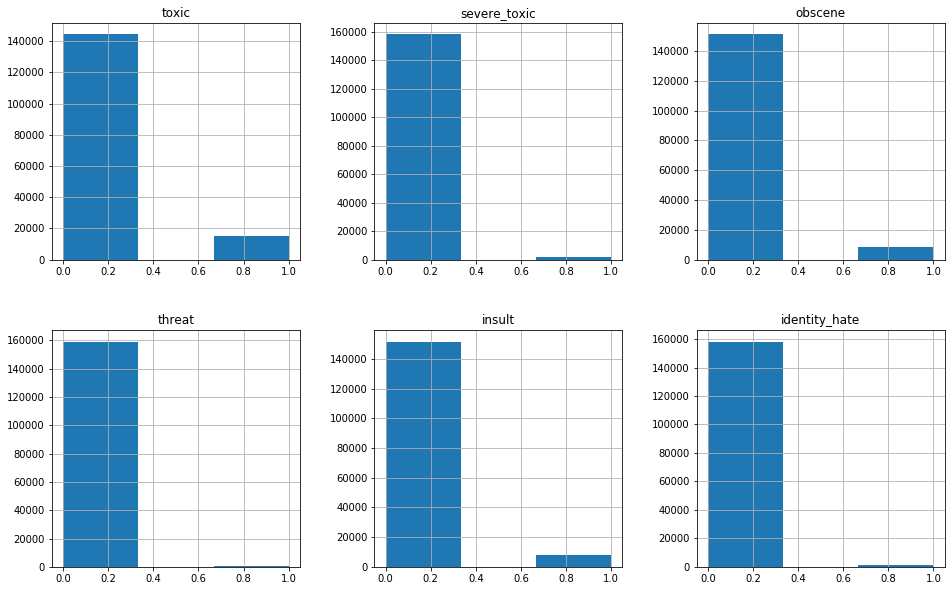

In [0]:
fig, axes = plt.subplots(2,3, figsize=(16, 10))
i = 2
for triaxis in axes:
    for axis in triaxis:
        train.hist(column = train.columns[i], bins = 3, ax=axis)
        i = i+1
plt.show()

Toxic, obscene and insult categories have the most positive (=1) observations. Let see if this is also the issue for test set.

In [0]:
test_set.describe()

toxic   severe_toxic  ...         insult  identity_hate
count  153164.000000  153164.000000  ...  153164.000000  153164.000000
mean       -0.542530      -0.579895  ...      -0.559916      -0.577642
std         0.572465       0.498408  ...       0.539594       0.503260
min        -1.000000      -1.000000  ...      -1.000000      -1.000000
25%        -1.000000      -1.000000  ...      -1.000000      -1.000000
50%        -1.000000      -1.000000  ...      -1.000000      -1.000000
75%         0.000000       0.000000  ...       0.000000       0.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 6 columns]

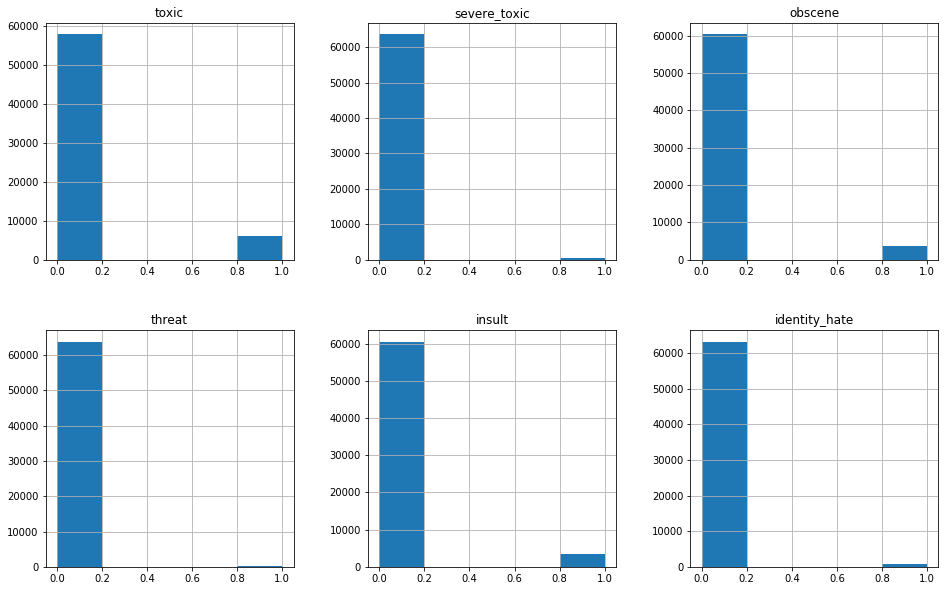

In [0]:
fig, axes = plt.subplots(2,3, figsize=(16, 10))
i = 2
for triaxis in axes:
    for axis in triaxis:
        test_set.hist(column = test_set.columns[i], bins = 5, ax=axis)
        i = i+1
plt.show()

Fortunately, the distribution looks very similar to the training set, so there would not be any problems with imbalanced data between train and test.


Are there any rows with missing data?

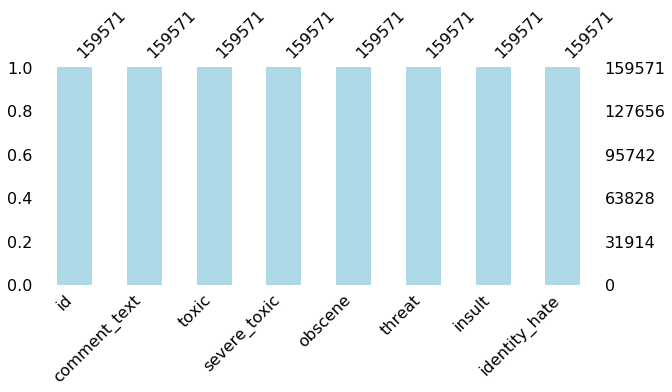

In [0]:
msno.bar(train, color='lightblue', figsize=(10,4))

All columns have data in 100% of observations.

Let's explore comment_text column which consists of Wikipedia posts.

In [0]:
lens = train.comment_text.str.len()
print(f'Mean of the comments length: {lens.mean()}')
print(f'Standard deviation of the comments length: {lens.std()}')
print(f'Max of the comments length: {lens.max()}')
print(f'Min of the comments length: {lens.min()}')

Mean of the comments length: 394.0732213246768
Standard deviation of the comments length: 590.7202819048923
Max of the comments length: 5000
Min of the comments length: 6


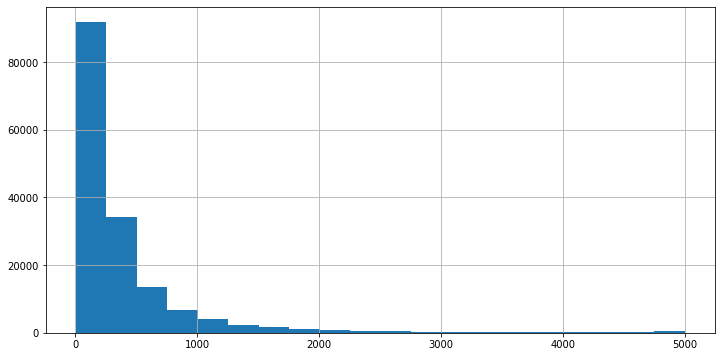

In [0]:
lens.hist(figsize = (12,6), bins = 20)

We clearly see that the distribution of lengths is right skewed, so we are dealing mostly with short comments.

Let's see if the categories are correlated.

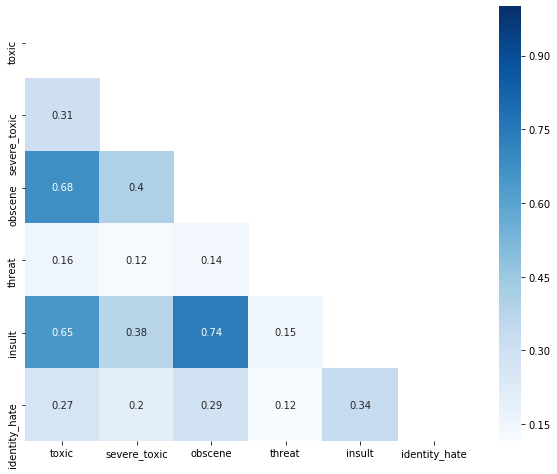

In [0]:
label_cols = train.iloc[:,2:].columns
train['other'] = 1-train[label_cols].max(axis=1)
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="Blues",
            mask=mask)

We can see that **insult** is highly correlated with **obscene** and **toxic**, as well as **obscene** is higly correlated with **toxic**.

# Text Mining Analysis

### Wordclouds

In [0]:
stopword=set(STOPWORDS)
stopword.add('NIGGER')
stopword.add('JEW')

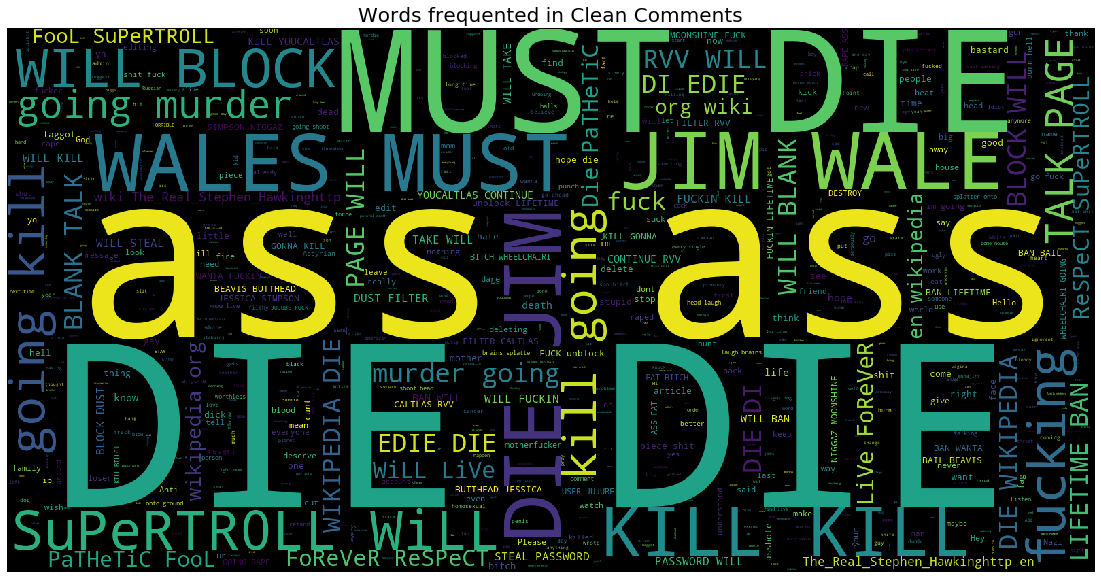

In [0]:
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",
              max_words=2000,
              stopwords=stopword,
              width=1600, height=800)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.tight_layout(pad=0)
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc)
plt.show()

### Length to category correlation

### Topic modelling per category

### Unique words / unique comments

### Senitment?

# Preprocessing

# Classifier

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import model_from_json

In [0]:
def save_model(model,name):
    json_string = model.to_json()
    open('drive/My Drive/Toxic_Comments/'+name+'_architecture.json', 'w').write(json_string)
    model.save_weights('drive/My Drive/Toxic_Comments/'+name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open('drive/My Drive/Toxic_Comments/'+name+'_architecture.json').read())
    model.load_weights('drive/My Drive/Toxic_Comments/'+name +'_weights.h5')
    return(model)

In [0]:

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test = test_set[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test_set["comment_text"]

In [0]:
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list(list_sentences_train))
word_index = tokenizer.word_index
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
max_length = 200
padding_type='post'
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen, padding=padding_type)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen, padding=padding_type)

In [0]:
embed_size = 128

In [80]:
model = Sequential([
    Embedding(vocab_size, embed_size, input_length=max_length),
    Bidirectional(GRU(64, dropout=0.1, return_sequences=True)),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(6, activation='softmax')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 200, 128)          74112     
_________________________________________________________________
dropout_10 (Dropout)         (None, 200, 128)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200, 128)          98816     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)               

In [82]:
batch_size = 1024
epochs = 2
history = model.fit(X_train,
                    y_train, 
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    shuffle=True)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 194s 1ms/sample - loss: 0.2271 - acc: 0.9634 - val_loss: 0.2264 - val_acc: 0.9627
Epoch 2/2
143613/143613 [==============================] - 192s 1ms/sample - loss: 0.2253 - acc: 0.9634 - val_loss: 0.2250 - val_acc: 0.9626


In [84]:
score = model.evaluate(X_test, 
                       y_test,
                       batch_size = 1024,
                       verbose = 1)

63978/63978 [==============================] - 18s 286us/sample - loss: 0.2269 - acc: 0.9617


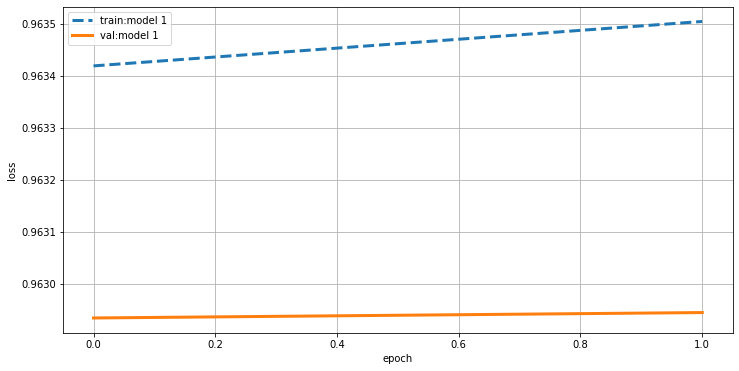

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['acc']
    val_loss = hist['val_acc']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)


plt.figure(figsize=(12,6))

plot_loss(history.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

# plt.savefig('drive/My Drive/MLP_loss.png', bbox_inches='tight')
plt.show()

In [0]:
save_model(model, "lstm_1st")

## Exploring embeddings

In [0]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [87]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(20000, 128)


In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')